# PROJECT LUNG DISEASES

## REQUIREMENT

In [4]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

### Initiation Directory

In [5]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [6]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale nilai piksel ke rentang [0, 1]
    zoom_range=0.2 #,            # Memperbesar gambar hingga 20%
    #fill_mode='nearest'        # Mengisi piksel yang kosong dengan piksel terdekat
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(299, 299),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 32
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(299, 299),
    class_mode='categorical',
    batch_size = 16
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [ ]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, input_shape=(299, 299, 3))
# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_resnet.summary())

In [ ]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

In [ ]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



In [ ]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [7]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 9, 9, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 207365    
Total params: 20,231,749
Trainable params: 207,365
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [8]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 200s 959ms/step - loss: 1.4635 - acc: 0.4160 - val_loss: 1.2128 - val_acc: 0.6589
Epoch 2/30
190/190 [==============================] - 148s 777ms/step - loss: 1.2073 - acc: 0.6044 - val_loss: 0.9889 - val_acc: 0.7220
Epoch 3/30
190/190 [==============================] - 149s 781ms/step - loss: 1.0660 - acc: 0.6521 - val_loss: 0.8579 - val_acc: 0.7403
Epoch 4/30
190/190 [==============================] - 147s 774ms/step - loss: 0.9760 - acc: 0.6720 - val_loss: 0.7816 - val_acc: 0.7648
Epoch 5/30
190/190 [==============================] - 149s 783ms/step - loss: 0.9043 - acc: 0.6946 - val_loss: 0.7301 - val_acc: 0.7678
Epoch 6/30
190/190 [==============================] - 149s 785ms/step - loss: 0.8570 - acc: 0.7120 - val_loss: 0.6873 - val_acc: 0.7678
Epoch 7/30
190/190 [==============================] - 146s 768ms/step - loss: 0.8176 - acc: 0.7211 - val_loss: 0.6432 - val_acc: 0.7760
Epoch 8/30
190/190 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

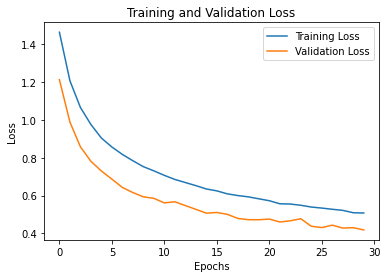

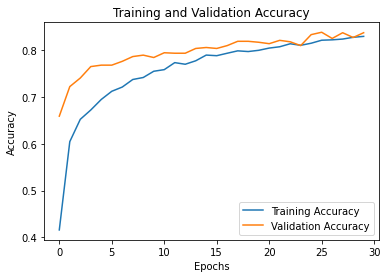

In [13]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 10s 153ms/step - loss: 0.4189 - acc: 0.8371
Loss: 0.41890332102775574
Accuracy: 0.837067186832428


In [15]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



190/190 [==============================] - 129s 679ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20380   0.20246   0.20312      1220
            covid19    0.19199   0.20837   0.19985      1243
             normal    0.21053   0.19433   0.20211      1235
       tuberculosis    0.20766   0.20855   0.20810      1170
    viral_pneumonia    0.19020   0.18894   0.18957      1212

           accuracy                        0.20049      6080
          macro avg    0.20083   0.20053   0.20055      6080
       weighted avg    0.20078   0.20049   0.20050      6080



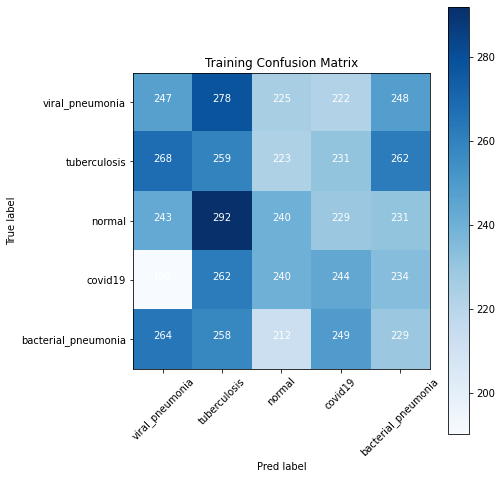

In [16]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [ ]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

In [ ]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

In [ ]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

In [ ]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



In [ ]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()